# 1D Convolutional Neural Network

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.4.1


## Load Data

In [3]:
df = pd.read_csv('datasets/df_preprocessed.csv')
df.drop('Unnamed: 0', 1, inplace=True)

In [4]:
df['label'].value_counts()

anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: label, dtype: int64

In [5]:
label_and_code = dict(zip(df['label_code'].unique(), df['label'].unique()))
label_and_code

{0: 'anger', 1: 'happy', 2: 'sadness', 3: 'love', 4: 'fear'}

## Define Needed Parameters

In [6]:
sentences = [row.split() for row in df['cleaned_tweets']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

In [9]:
print('The Amount of Vocabularies: {}'.format(len(word_freq)))
print('Maximum Tweet Length: {}'.format(max(df['tweets_length'])))

The Amount of Vocabularies: 14650
Maximum Tweet Length: 83


__vocab_size__: using 14650 vocabularies for input dimension. <br>
__embedding_dim__: 300 for output dimension. <br>
__max_length__: The maximum length of tweets is 83, so we take 83 for the maximum input length.<br>

In [10]:
vocab_size = len(word_freq)
embedding_dim = 300
max_length = 83

### Data Split

In [11]:
train_set, validation_set = train_test_split(df, train_size=0.7)
print('Training Set: {} rows\nValidation Set: {} rows'.format(len(train_set), len(validation_set)))

Training Set: 3080 rows
Validation Set: 1321 rows


### Word Tokenizer

In [12]:
# tokenize tweets
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_set["cleaned_tweets"])
word_index = tokenizer.word_index

### Tweets to Sequences
Transform text from tweets to Tensorflow's sequences.

In [13]:
def encode(text):
    return tokenizer.texts_to_sequences(text)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def decode(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return words

#### Train Data

In [14]:
train_sequences = encode(train_set["cleaned_tweets"])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

In [15]:
print('before pad_sequences: ',len(train_sequences[0]))
print('after pad_sequences: ',len(train_padded[0]))

print('before pad_sequences: ',len(train_sequences[1]))
print('after pad_sequences: ',len(train_padded[1]))

print('before pad_sequences: ',len(train_sequences[10]))
print('after pad_sequences: ',len(train_padded[10]))

before pad_sequences:  20
after pad_sequences:  83
before pad_sequences:  27
after pad_sequences:  83
before pad_sequences:  22
after pad_sequences:  83


In [17]:
print(train_padded.shape)

(3080, 83)


#### Test

In [18]:
validation_sequences = encode(validation_set['cleaned_tweets'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post')

print(validation_padded.shape)

(1321, 83)


### Encode Labels to Categorical

In [19]:
training_label_enc = to_categorical(train_set['label_code'])
validation_label_enc = to_categorical(validation_set['label_code'])

In [20]:
train_padded.shape, validation_padded.shape, training_label_enc.shape, validation_label_enc.shape

((3080, 83), (1321, 83), (3080, 5), (1321, 5))

## 1D CNN Architecture
Creating model for 1D Convolutional Neural Network

In [21]:
def eval_model(x, y, model):
    loss, accuracy = model.evaluate(x, y, verbose=False)
    return loss, accuracy

In [24]:
def create_model(vocab, dim, length): # BEST MODEL
    model = Sequential()
    model.add(Embedding(vocab+1, dim, input_length=length))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(500, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(5, activation='softmax'))               
    return model

In [25]:
model_cnn = create_model(vocab_size, embedding_dim, max_length)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 83, 300)           4395300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 83, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 79, 256)           384256    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               128500    
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)              

### Model Visualization

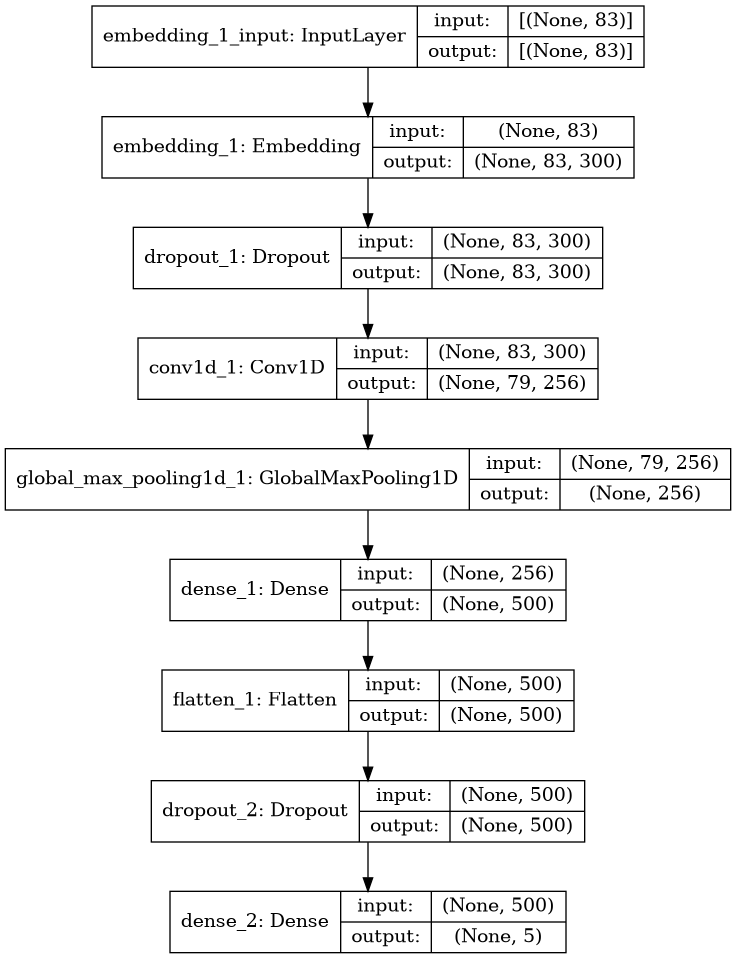

In [26]:
plot_model(model_cnn, to_file='results/visualize_model.png', show_shapes=True, show_layer_names=True)

### Model Training

In [27]:
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es_callbacks = [EarlyStopping(monitor='val_loss'),
             ModelCheckpoint(filepath='models/model_checkpoint_cnn.h5', 
                             monitor='val_accuracy', save_best_only=True, 
                             mode='max')]


history = model_cnn.fit(train_padded,
          training_label_enc,
          epochs=100,
          validation_data=(validation_padded, validation_label_enc),
          callbacks=[es_callbacks])

Epoch 1/100
97/97 [==============================] - 5s 47ms/step - loss: 1.5795 - accuracy: 0.2574 - val_loss: 1.1833 - val_accuracy: 0.5602
Epoch 2/100
97/97 [==============================] - 4s 45ms/step - loss: 0.9744 - accuracy: 0.6523 - val_loss: 0.9380 - val_accuracy: 0.6389
Epoch 3/100
97/97 [==============================] - 4s 45ms/step - loss: 0.2874 - accuracy: 0.9172 - val_loss: 1.1130 - val_accuracy: 0.6495


In [28]:
model_cnn.save('models/model_cnn.h5')

### Model Evaluation

#### Accuracy and Loss Plot

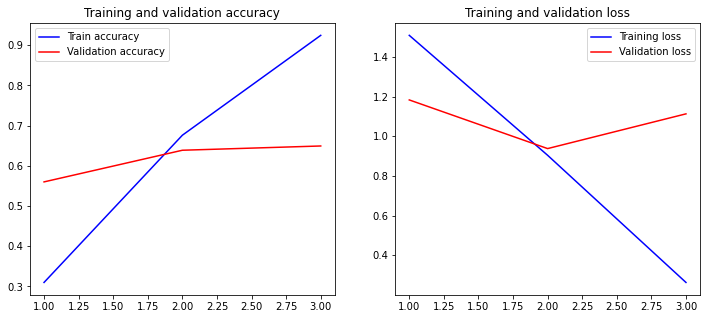

In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, accuracy, 'b', label='Train accuracy')
plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('results/cnn_graph.png')

#### Model Architecture Evaluation (Train and Validation Data)

In [30]:
loss_train_best, accuracy_train_best = eval_model(train_padded, training_label_enc, model_cnn)
loss_test_best, accuracy_test_best = eval_model(validation_padded, validation_label_enc, model_cnn)

In [31]:
print('Train [{}][{}]'.format(accuracy_train_best, loss_train_best))
print('Test [{}][{}]'.format(accuracy_test_best, loss_test_best))

Train [0.9977272748947144][0.03196936473250389]
Test [0.6495079398155212][1.1130433082580566]


### Model Prediction

In [32]:
def encode_predict(text):
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=max_length, padding='post')
    return text

In [33]:
df_encoded = encode_predict(df['cleaned_tweets'])
result_classes = np.argmax(model_cnn.predict(df_encoded), axis=-1)

### Model Evaluation

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [35]:
(unique, counts) = np.unique(result_classes, return_counts=True)

frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 1125],
       [   1,  942],
       [   2, 1052],
       [   3,  635],
       [   4,  647]])

In [36]:
ground_truth = np.asarray(df['label_code'])

In [37]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(ground_truth, result_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ground_truth, result_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ground_truth, result_classes, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ground_truth, result_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.893206
Precision: 0.899324
Recall: 0.897532
F1 score: 0.898025
